In [ ]:
from google.colab import drive
drive.mount('/content/drive')

: 

#**Importando as dependências do projeto**

In [233]:
import sys
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib
import tensorflow as tf
from tensorflow import keras

In [234]:
#produtibilidade (SEED)
# Isso garante que os resultados sejam sempre iguais, eliminando o fator sorte.
SEED = 42

os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

tf.random.set_seed(SEED) # Trava o TensorFlow

# Configurações para forçar determinismo (opcional, mas recomendado)
tf.config.experimental.enable_op_determinism()

# Atalhos do Keras
Sequential = keras.models.Sequential
LSTM = keras.layers.LSTM
Dense = keras.layers.Dense
Dropout = keras.layers.Dropout
Input = keras.layers.Input
EarlyStopping = keras.callbacks.EarlyStopping

# Configuração visual e hardware
sns.set_style('darkgrid')
print(f"Versão do TensorFlow: {tf.__version__}")

# Forçar CPU (Conforme nossa decisão anterior)
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
print(" Configuração concluída. Seed fixado em 42.")

Versão do TensorFlow: 2.19.0
 Configuração concluída. Seed fixado em 42.


#Aquisição de Dados Históricos

In [235]:
df = pd.read_csv('/content/drive/MyDrive/teste_fase4_final/PETR4.SA.csv')

#Visualização Inicial
print("\nPrimeiras 2 linhas do DataFrame:")
print(df.head(2))
print("\nShape: ", df.shape)



Primeiras 2 linhas do DataFrame:
         Date  Adj Close      Close       High        Low       Open    Volume
0  2018-01-02   4.410662  16.549999  16.549999  16.190001  16.190001  33461800
1  2018-01-03   4.450639  16.700001  16.719999  16.370001  16.490000  55940900

Shape:  (1992, 7)


#Engenharia de Features e Definição do Target

###Defindo o Target


O Ajusted Close representa o valor econômico real do ativo, incorporando **dividendos**, **splits/grupamentos** e **outros eventos corporativos**. O alvo sendo Adj Close representa ganho/perda efetiva do investidos, e não apenas a variação nominal diária. Portanto, devemos usar o retorno real do ativo.

In [236]:
#AdjClose_t+1 é o preço do dia seguinte.
df['AdjClose_t+1']  = df['Adj Close'].shift(-1)
df.dropna(inplace=True)

#Features e alvo usados no modelo
df = df.reset_index()[['Date', 'Adj Close', 'AdjClose_t+1']]
print(df.head(2))

         Date  Adj Close  AdjClose_t+1
0  2018-01-02   4.410662      4.450639
1  2018-01-03   4.450639      4.458633


Apesar da não estacionariedade inerente às séries financeiras, optou-se pelo uso de uma arquitetura LSTM, que não requer estacionariedade estrita e é capaz de aprender dependências temporais não-lineares a partir de janelas móveis de observações. A normalização dos dados foi aplicada para garantir estabilidade numérica e adequada convergência durante o treinamento.

#Sanity Checks (Verificação de Consistência)


[Verificando a ordem cronológica]
Dados ordenados cronologicamente.
Primeiro registro: 2018-01-02
Último registro: 2026-01-06
✅ Dados limpos! 1991 registros carregados.


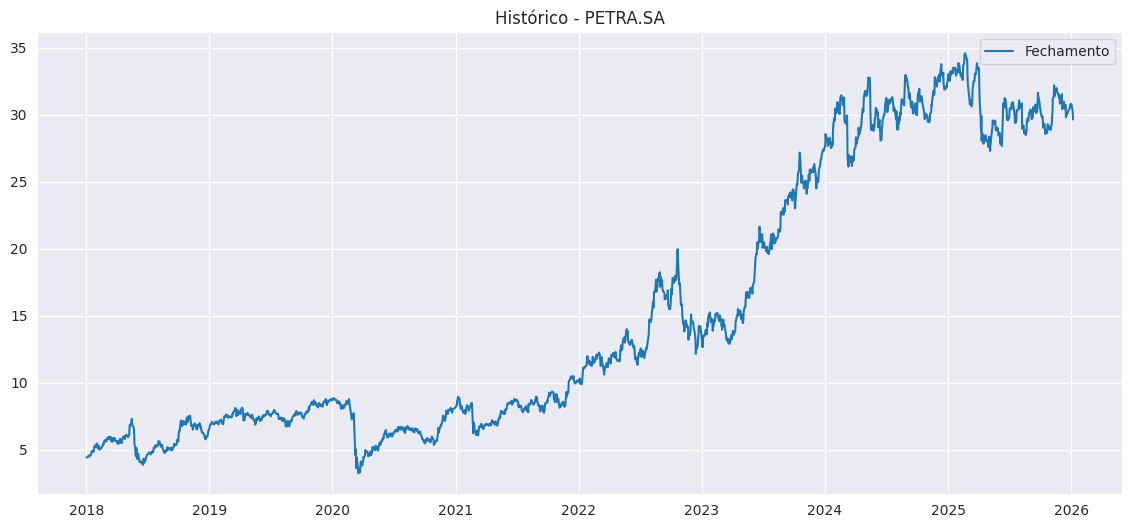

In [237]:
# ---  Verificar a ordem cronológica dos dados ---
print("\n[Verificando a ordem cronológica]")
# Garante que o índice esteja ordenado do mais antigo para o mais novo
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

print("Dados ordenados cronologicamente.")
print(f"Primeiro registro: {df.index.min().date()}")
print(f"Último registro: {df.index.max().date()}")

print(f"✅ Dados limpos! {len(df)} registros carregados.")

# Visualizar
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['Adj Close'], label='Fechamento')
plt.title(f'Histórico - PETRA.SA')
plt.legend()
plt.show()

#Pré-processamento e Escalonamento (MinMaxScaler)

Neste passo, aplicaremos o MinMaxScaler separadamente aos Features ($X$) e ao Target ($Y$) no formato NumPy Array 2D.

In [238]:
# --- Variáveis de Coluna (Atualizadas para incluir todas as colunas de preço) ---
FEATURE_COLS = ['Adj Close']
TARGET_COL = 'AdjClose_t+1'

print(f"Features de Entrada (X) corrigidas: {FEATURE_COLS}")
print(f"Target de Saída (Y) mantido: {TARGET_COL}")

X_features = df[FEATURE_COLS].values
Y_target = df[TARGET_COL].values.reshape(-1, 1)

# Inicializar Scalers (Dois Scalers Independentes)
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X_features)
Y_scaled = scaler_Y.fit_transform(Y_target)

# Verificação de Shapes e Escalonamento
print("\n--- Verificação de Shapes e Escalonamento ---")
print(f"Shape de X (Features escalonadas): {X_scaled.shape}")
print(f"Shape de Y (Target escalonado): {Y_scaled.shape}")
print(f"Mínimo/Máximo de X_scaled: {X_scaled.min():.4f} / {X_scaled.max():.4f}")
print(f"Mínimo/Máximo de y_scaled: {Y_scaled.min():.4f} / {Y_scaled.max():.4f}")


Features de Entrada (X) corrigidas: ['Adj Close']
Target de Saída (Y) mantido: AdjClose_t+1

--- Verificação de Shapes e Escalonamento ---
Shape de X (Features escalonadas): (1991, 1)
Shape de Y (Target escalonado): (1991, 1)
Mínimo/Máximo de X_scaled: 0.0000 / 1.0000
Mínimo/Máximo de y_scaled: 0.0000 / 1.0000


#Criação de Sequências (Windowing) e Target

Esta etapa é a transformação final dos dados 2D (escalonados) no formato 3D exigido pela LSTM.

In [239]:
# Definição das Constantes do Modelo
WINDOW_SIZE = 60      # W: Número de dias (timesteps) que o modelo verá no passado (input)
HORIZONTE = 1        # H: Número de dias que o modelo tentará prever no futuro (output)
N_FEATURES = X_scaled.shape[1]    # F: Número de features de entrada ( AdjClose)

print(f"Configuração: Janela (W)={WINDOW_SIZE}, Horizonte (H)={HORIZONTE}, Features={N_FEATURES}")

Configuração: Janela (W)=60, Horizonte (H)=1, Features=1


In [240]:
def create_sequences_univariate(series_scaled, WINDOW_SIZE):
    """
    Previsão univariada (t+1):
    X: últimos 'window_size' valores da série (1 feature)
    y: próximo valor da série
    """
    X_seq, y_seq = [], []
    series_scaled = np.asarray(series_scaled).reshape(-1)  # garante 1D

    for i in range(WINDOW_SIZE, len(series_scaled)):
        X_seq.append(series_scaled[i - WINDOW_SIZE:i])  # (window_size,)
        y_seq.append(series_scaled[i])                  # escalar (t+1)

    X_seq = np.array(X_seq)                 # (N, window_size)
    y_seq = np.array(y_seq).reshape(-1, 1)  # (N, 1)

    # Formato LSTM: (Amostras, Timesteps, Features=1)
    X_seq = X_seq.reshape(X_seq.shape[0], X_seq.shape[1], 1)

    return X_seq, y_seq

# Aplicação (ex.: use apenas a série do target escalada)
# Se você tiver Y_scaled como (N,1), passe Y_scaled:
X_sequences, Y_sequences = create_sequences_univariate(Y_scaled, WINDOW_SIZE)

print("\n--- Verificação do Shape Final (Formato LSTM - Univariado) ---")
print(f"Shape final de X (Entrada): {X_sequences.shape} (Amostras, Timesteps, Features=1)")
print(f"Shape final de Y (Saída):   {Y_sequences.shape} (Amostras, 1)")



--- Verificação do Shape Final (Formato LSTM - Univariado) ---
Shape final de X (Entrada): (1931, 60, 1) (Amostras, Timesteps, Features=1)
Shape final de Y (Saída):   (1931, 1) (Amostras, 1)


In [241]:
def create_sequences(X, Y, window_size, horizonte):
    X_seq, Y_seq = [], []

    for i in range(window_size, len(X) - horizonte + 1):
        X_seq.append(X[i - window_size:i, :])
        Y_seq .append(Y[i:i + horizonte].flatten())

    return np.array(X_seq), np.array(Y_seq )

# Aplicação da função
X_sequences, Y_sequences = create_sequences(X_scaled, Y_scaled, WINDOW_SIZE, HORIZONTE)

# Verificação do Shape Final
print("\n--- Verificação do Shape Final (Formato LSTM) ---")
print(f"Shape final de X (Features de Entrada): {X_sequences.shape} (Amostras, Timesteps, Features)")
print(f"Shape final de Y (Targets de Saída): {Y_sequences.shape} (Amostras, Horizonte)")


--- Verificação do Shape Final (Formato LSTM) ---
Shape final de X (Features de Entrada): (1931, 60, 1) (Amostras, Timesteps, Features)
Shape final de Y (Targets de Saída): (1931, 1) (Amostras, Horizonte)


#Divisão Treino/Teste (Temporal Split)

Para manter a robustez, usaremos uma divisão de 70% para Treino, 10% para Validação e 20% para Teste. A ordem cronológica é estritamente mantida: Treino (mais antigo) --> Validação --> Teste (mais recente).

In [242]:
# Definição das Proporções (Recomendado para Time Series)
TRAIN_RATIO = 0.7   # 70%
VAL_RATIO = 0.15     # 15%
N_SAMPLES = X_sequences.shape[0]

# Cálculo dos Pontos de Divisão
train_split_point = int(N_SAMPLES * TRAIN_RATIO)
val_split_point = int(N_SAMPLES * (TRAIN_RATIO + VAL_RATIO))

# Divisão Cronológica (Temporal Split)
# TREINO (Dados mais antigos)
X_train = X_sequences[:train_split_point]
Y_train = Y_sequences[:train_split_point]

# VALIDAÇÃO (Dados intermediários - usado para Early Stopping)
X_val = X_sequences[train_split_point:val_split_point]
Y_val = Y_sequences[train_split_point:val_split_point]

# TESTE (Dados mais recentes - usado para avaliação final não enviesada)
X_test = X_sequences[val_split_point:]
Y_test = Y_sequences[val_split_point:]

# Verificação dos Shapes
print(f"\nNúmero total de amostras (janelas criadas): {N_SAMPLES}")
print(f"Amostras de Treino: {len(X_train)} ({TRAIN_RATIO*100:.0f}%)")
print(f"Amostras de Validação: {len(X_val)} ({VAL_RATIO*100:.0f}%)")
print(f"Amostras de Teste: {len(X_test)} ({100 - (TRAIN_RATIO*100 + VAL_RATIO*100):.0f}%)")
print("\nShapes dos conjuntos:")
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")


Número total de amostras (janelas criadas): 1931
Amostras de Treino: 1351 (70%)
Amostras de Validação: 290 (15%)
Amostras de Teste: 290 (15%)

Shapes dos conjuntos:
X_train shape: (1351, 60, 1)
X_val shape: (290, 60, 1)
X_test shape: (290, 60, 1)


#Definição do Modelo LSTM

Utilizaremos uma arquitetura de LSTM Empilhada (Stacked LSTM), que atua como um Encoder-Decoder implícito. Isso permite que a rede capture padrões mais complexos e profundos no histórico de 60 dias (Janela de Observação) antes de fazer a previsão one-step.

In [251]:
# Treinamento do Modelo
EPOCHS = 50 # Definimos um número alto de épocas, mas o Early Stopping irá parar antes.
BATCH_SIZE = 64 # Tamanho do batch (pode ser ajustado)

In [252]:
tf.keras.backend.clear_session() # Limpa a memória de modelos antigos
print(f'\nTamanho da Janela: {WINDOW_SIZE}')
print(f'Número de Features: {N_FEATURES}')
print(f'Tamanho do Horizonte: {HORIZONTE}')

# Primeira Camada LSTM (Encoder)
# return_sequences=True: A saída ainda será uma sequência, necessária para empilhar LSTMs

model = Sequential([
    Input(shape=(X_train.shape[1], 1)),   #janela, feature
    LSTM(100, return_sequences=True),
    Dropout(0.15),
    LSTM(50, return_sequences=False),
    Dropout(0.15),
    Dense(25, activation='linear'),
    Dropout(0.15),
    Dense(1, activation='linear') # Saída: Preço previsto
])

# Sumário do Modelo
print("\n--- Sumário da Arquitetura do Modelo ---")
model.summary()


Tamanho da Janela: 60
Número de Features: 1
Tamanho do Horizonte: 1

--- Sumário da Arquitetura do Modelo ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 72,301 (282.43 KB)

 Trainable params: 72,301 (282.43 KB)

 Non-trainable params: 0 (0.00 B)

#Treinamento e Otimização

Nesta etapa, usaremos o otimizador Adam e a função de perda MAE (Mean Absolute Error). O componente de otimização mais importante é o Early Stopping, que monitora a perda no conjunto de validação para evitar overfitting.


--- Iniciando o Treinamento do Modelo LSTM ---
Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 176ms/step - loss: 0.0944 - mae: 0.0944 - mape: 33975.2656 - val_loss: 0.0496 - val_mae: 0.0496 - val_mape: 6.0831
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 0.0312 - mae: 0.0312 - mape: 20044.0371 - val_loss: 0.0845 - val_mae: 0.0845 - val_mape: 10.3387
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.0307 - mae: 0.0307 - mape: 22725.0117 - val_loss: 0.0579 - val_mae: 0.0579 - val_mape: 7.1208
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.0284 - mae: 0.0284 - mape: 19496.6387 - val_loss: 0.0327 - val_mae: 0.0327 - val_mape: 4.0425
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - loss: 0.0238 - mae: 0.0238 - mape: 19651.1055 - val_loss: 0.0461 - val_mae: 0.0461 - val_mape: 5.6865
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - loss: 0.0264 - mae: 0.0264 - mape: 16258.4287 - val_loss: 0.0330 - val_mae: 0.0330 - val_mape: 4.0787
Epoch 7/50
22/22 

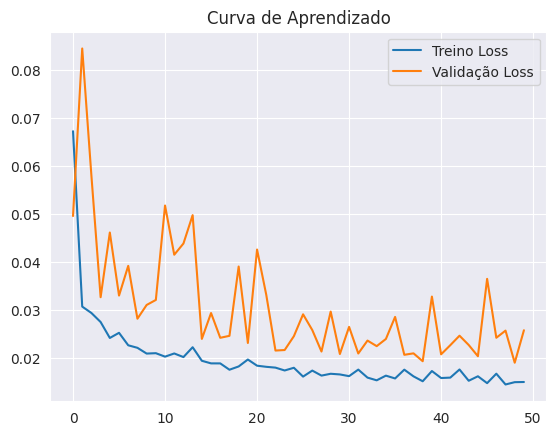


Treinamento concluído. O modelo usou a melhor época com base na val_loss.


In [253]:
# Compilação do Modelo
# Otimizador: Adam (Padrão para Deep Learning)
# Função de Perda (Loss): MAE (Menos sensível a outliers que o MSE, ideal para Retornos)
model.compile( optimizer='adam',
      loss='mae',
      metrics=['mae', 'mape'])

# Definição do Callback de Early Stopping
# Monitora a perda (loss) no conjunto de validação (val_loss)
# patience=10: Aguarda 10 épocas após a última melhora antes de parar
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True # Restaura os pesos da época que teve a melhor val_loss
)

print("\n--- Iniciando o Treinamento do Modelo LSTM ---")

history = model.fit(
    X_train,
    Y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, Y_val), # Usa o conjunto de validação para monitoramento
    callbacks=[early_stop]          # Aplica o Early Stopping
)

# Plotar curva de aprendizado
plt.plot(history.history['loss'], label='Treino Loss')
plt.plot(history.history['val_loss'], label='Validação Loss')
plt.title('Curva de Aprendizado')
plt.legend()
plt.show()

print("\nTreinamento concluído. O modelo usou a melhor época com base na val_loss.")

#Previsão e Pós-processamento

Este passo envolve três subprocessos:

1. Predição (Forecast): Gerar preço futuro escalonado (Y_pred_scaled).

2. Inverse Transform: Desescalonar os preços previstos usando o scaler_Y.

3. Recomposição do Preço: Usar o último preço conhecido (Adj Close) e aplicar os retornos previstos de forma iterativa para reconstruir a trajetória do preço.

In [254]:
# Predições em escala [0,1]
Y_pred_p = model.predict(X_test, verbose=0)   #(n_amostras, 1)

# Inverter escala para obter preços reais
Y_pred_real = scaler_Y.inverse_transform(Y_pred_p.reshape(-1,1)).ravel()
Y_test_real = scaler_Y.inverse_transform(Y_test.reshape(-1,1)).ravel()
print(f"Shape de Y_pred_scaled: {Y_pred_p.shape}")
print(f"Shape de Y_pred_real: {Y_pred_real.shape}")

print("y_train mean/min/max = ", Y_train.mean(), Y_train.min(), Y_train.max())
print("y_test mean/min/max  = ", Y_test.mean(), Y_test.min(), Y_test.max())
print("y_pred mean/min/max  = ", Y_pred_p.mean(), Y_pred_p.min(), Y_pred_p.max())

print("\nFormas:", Y_test_real.shape, Y_pred_real.shape)


Shape de Y_pred_scaled: (290, 1)
Shape de Y_pred_real: (290,)
y_train mean/min/max =  0.2014744408290592 0.0 0.650968298326687
y_test mean/min/max  =  0.8791613080971128 0.7676513104124574 1.0
y_pred mean/min/max  =  0.8806003 0.78139174 1.0071609

Formas: (290,) (290,)


In [255]:
# Naive: prever valor de hoje como sendo o valor de ontem (dentro do próprio teste)
y_pred_naive_p = np.zeros_like(Y_test_real)

# Para o primeiro ponto, não temos "ontem" dentro do teste.
# Opção simples: copiar o próprio valor real (impacta só 1 ponto nas métricas).
y_pred_naive_p[0] = Y_test_real[0]

# Para os demais, usa o valor real do passo anterior
y_pred_naive_p[1:] = Y_test_real[:-1]

# y_true_naive é o mesmo y_true_p (alvo verdadeiro)
y_true_naive_p = Y_test_real.copy()
# --- Modelo Naive: prever preço de amanhã como sendo o preço de hoje ---
# Modelo naive: previsão do preço t+1 = preço real de t
#y_pred_naive_p = Y_test_real[:-1]      # desloca 1 posição
#y_pred_naive_p = np.append(y_pred_naive_p, Y_test_real[-1])  # mantém mesmo tamanho

print("y_true_p min/max:", Y_test_real.min(), Y_test_real.max())
print("y_pred_p min/max:", y_pred_naive_p.min(), y_pred_naive_p.max())


y_true_p min/max: 27.29982185363769 34.5811882019043
y_pred_p min/max: 27.29982185363769 34.5811882019043


In [256]:

# Valores verdadeiros e previsões
y_true        = np.asarray(Y_test_real).ravel()       # escala real
y_pred_naive  = np.asarray(y_pred_naive_p).ravel()    # Naive em escala real
y_pred_lstm   = np.asarray(Y_pred_real).ravel()       # LSTM em escala real

eps = 1e-8  # evita divisão por zero no MAPE

# -----------------------------
# Métricas Naive
# -----------------------------
rmse_naive = np.sqrt(mean_squared_error(y_true, y_pred_naive))
mae_naive  = mean_absolute_error(y_true, y_pred_naive)

mape_naive = np.mean(
    np.abs((y_true - y_pred_naive) / (y_true + eps))
) * 100

smape_naive = np.mean(
    2 * np.abs(y_true - y_pred_naive) /
    (np.abs(y_true) + np.abs(y_pred_naive) + eps)
) * 100

mase_naive = 1.0  # benchmark

# -----------------------------
# Métricas LSTM
# -----------------------------
rmse_lstm = np.sqrt(mean_squared_error(y_true, y_pred_lstm))
mae_lstm  = mean_absolute_error(y_true, y_pred_lstm)

mape_lstm = np.mean(
    np.abs((y_true - y_pred_lstm) / (y_true + eps))
) * 100

smape_lstm = np.mean(
    2 * np.abs(y_true - y_pred_lstm) /
    (np.abs(y_true) + np.abs(y_pred_lstm) + eps)
) * 100

mase_lstm = np.inf if mae_naive == 0 else (mae_lstm / mae_naive)

# -----------------------------
# Impressão comparativa (como você já tinha)
# -----------------------------
print("sMAPE Naive:", smape_naive)
print("sMAPE LSTM :", smape_lstm)

print("\n       Modelo Naive:         Modelo LSTM")
print(f"RMSE : {rmse_naive:.4f}            |   {rmse_lstm:.4f}")
print(f"MAE  : {mae_naive:.4f}             |   {mae_lstm:.4f}")
print(f"MAPE : {mape_naive:.4f}            |   {mape_lstm:.4f}")
print(f"MASE : {mase_naive:.4f}            |   {mase_lstm:.4f}")

# -----------------------------
# Impressão no formato "Resultados Finais"
# -----------------------------
print("\n--- Resultados Finais (Naive) ---")
print(f"MAE (Erro Médio Absoluto): R$ {mae_naive:.2f}")
print(f"RMSE (Raiz do Erro Quadrático): R$ {rmse_naive:.2f}")
print(f"MAPE (Erro Percentual): {mape_naive:.2f}%")

print("\n--- Resultados Finais (LSTM) ---")
print(f"MAE (Erro Médio Absoluto): R$ {mae_lstm:.2f}")
print(f"RMSE (Raiz do Erro Quadrático): R$ {rmse_lstm:.2f}")
print(f"MAPE (Erro Percentual): {mape_lstm:.2f}%")


sMAPE Naive: 1.0097438311661233
sMAPE LSTM : 1.7475725133722702

       Modelo Naive:         Modelo LSTM
RMSE : 0.4325            |   0.7535
MAE  : 0.3095             |   0.5380
MAPE : 1.0112            |   1.7535
MASE : 1.0000            |   1.7384

--- Resultados Finais (Naive) ---
MAE (Erro Médio Absoluto): R$ 0.31
RMSE (Raiz do Erro Quadrático): R$ 0.43
MAPE (Erro Percentual): 1.01%

--- Resultados Finais (LSTM) ---
MAE (Erro Médio Absoluto): R$ 0.54
RMSE (Raiz do Erro Quadrático): R$ 0.75
MAPE (Erro Percentual): 1.75%


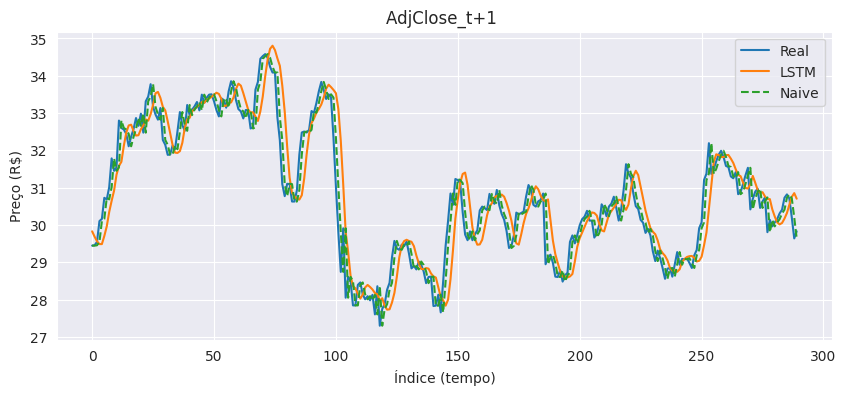

In [257]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(Y_test_real, label='Real')
plt.plot(Y_pred_real, label='LSTM')
plt.plot(y_pred_naive_p, label='Naive', linestyle='--') # Added naive plot
plt.title('AdjClose_t+1 ')
plt.xlabel('Índice (tempo)')
plt.ylabel('Preço (R$)')
plt.legend()
plt.grid(True)
plt.show()

In [258]:
import os
import joblib
# Criar pasta models se não existir
os.makedirs('/content/drive/MyDrive/teste_fase4_final', exist_ok=True)

# Salvar Modelo
model.save('/content/drive/MyDrive/teste_fase4_final/lstm_model.keras')
print("Modelo salvo em models/lstm_model.keras")

# Salvar Scaler
joblib.dump(scaler_X, '/content/drive/MyDrive/teste_fase4_final/scaler_X.pkl')
print("Scaler salvo em models/scaler_X.pkl")
joblib.dump(scaler_Y, '/content/drive/MyDrive/teste_fase4_final/scaler_Y.pkl')
print("Scaler salvo em models/scaler_Y.pkl")

Modelo salvo em models/lstm_model.keras
Scaler salvo em models/scaler_X.pkl
Scaler salvo em models/scaler_Y.pkl


In [222]:
def comparar_previsoes(y_real, y_pred, y_naive=None, start_idx=0):
    df = pd.DataFrame({
        'Indice': np.arange(start_idx, start_idx + len(y_real)),
        'Valor_Real_R$': y_real,
        'Previsto_LSTM_R$': y_pred
    })

    # Diferenças LSTM
    df['Erro_LSTM_R$'] = df['Previsto_LSTM_R$'] - df['Valor_Real_R$']
    df['Erro_LSTM_%']  = (df['Erro_LSTM_R$'] / df['Valor_Real_R$']) * 100

    # Baseline Naive (opcional)
    if y_naive is not None:
        df['Previsto_Naive_R$'] = y_naive
        df['Erro_Naive_R$'] = df['Previsto_Naive_R$'] - df['Valor_Real_R$']
        df['Erro_Naive_%']  = (df['Erro_Naive_R$'] / df['Valor_Real_R$']) * 100

    return df

df_resultados = comparar_previsoes(
    y_real=Y_test_real ,
    y_pred=Y_pred_real,
    y_naive=y_pred_naive_p,
    start_idx=0
)

df_resultados.head(10)

,Indice,Valor_Real_R$,Previsto_LSTM_R$,Erro_LSTM_R$,Erro_LSTM_%,Previsto_Naive_R$,Erro_Naive_R$,Erro_Naive_%
0,0,29.447073,29.847532,0.400459,1.359929,29.447073,0.000000,0.000000
1,1,29.455399,29.699400,0.244001,0.828376,29.447073,-0.008326,-0.028265
2,2,29.546919,29.561815,0.014896,0.050416,29.455399,-0.091520,-0.309746
3,3,30.104414,29.471312,-0.633102,-2.103022,29.546919,-0.557495,-1.851872
4,4,30.162659,29.456837,-0.705822,-2.340052,30.104414,-0.058245,-0.193102
5,5,30.728466,29.643644,-1.084822,-3.530348,30.162659,-0.565807,-1.841313
6,6,30.686865,29.899414,-0.787451,-2.566084,30.728466,0.041601,0.135567
7,7,31.011374,30.277681,-0.733692,-2.365881,30.686865,-0.324509,-1.046418
8,8,31.785202,30.598907,-1.186295,-3.732223,31.011374,-0.773829,-2.434556
9,9,31.452372,30.888906,-0.563465,-1.791487,31.785202,0.332830,1.058205


In [223]:
resumo = df_resultados[[
    'Erro_LSTM_R$', 'Erro_LSTM_%',
    'Erro_Naive_R$', 'Erro_Naive_%'
]].agg(['mean', 'median', 'std', 'min', 'max'])

print(resumo)


        Erro_LSTM_R$  Erro_LSTM_%  Erro_Naive_R$  Erro_Naive_%
mean        0.056972     0.208471      -0.001320      0.005619
median      0.046532     0.153359      -0.023169     -0.075057
std         0.790126     2.586673       0.433219      1.427050
min        -2.441519    -7.915779      -1.256426     -3.903905
max         3.722172    12.949925       1.896320      6.628251


In [224]:
df_resultados.sort_values(
    by='Erro_LSTM_%',
    key=np.abs,
    ascending=False
).head(10)


,Indice,Valor_Real_R$,Previsto_LSTM_R$,Erro_LSTM_R$,Erro_LSTM_%,Previsto_Naive_R$,Erro_Naive_R$,Erro_Naive_%
102,102,28.742805,32.464977,3.722172,12.949925,29.802700,1.059895,3.687513
101,101,29.802700,33.260822,3.458122,11.603386,31.033247,1.230547,4.128978
78,78,31.096121,33.899563,2.803442,9.015407,32.272781,1.176661,3.783946
100,100,31.033247,33.643879,2.610632,8.412371,32.335659,1.302412,4.196828
79,79,30.772764,33.229790,2.457026,7.984416,31.096121,0.323357,1.050788
147,147,30.843695,28.402176,-2.441519,-7.915779,30.104130,-0.739565,-2.397783
146,146,30.104130,27.911219,-2.192911,-7.284420,29.440416,-0.663713,-2.204726
104,104,28.051180,30.047047,1.995867,7.115090,29.910482,1.859303,6.628251
77,77,32.272781,34.393356,2.120575,6.570785,32.883568,0.610786,1.892575
251,251,31.204039,29.373163,-1.830875,-5.867431,30.069523,-1.134516,-3.635798


In [225]:
train_size = int(len(df) * 0.7)
idx_test_start = train_size + WINDOW_SIZE
dates_test = df.index[idx_test_start : idx_test_start + len(Y_test_real)]

In [230]:

def montar_df_comparacao_index(dates_index, y_real, y_lstm, y_naive, eps=1e-8):
    df = pd.DataFrame({
        "Date": pd.to_datetime(dates_index),
        "Real": np.asarray(y_real).ravel(),
        "LSTM": np.asarray(y_lstm).ravel(),
        "Naive": np.asarray(y_naive).ravel(),
    }).sort_values("Date").reset_index(drop=True)

    # Erros (R$)
    df["Err_LSTM_R$"]  = df["LSTM"]  - df["Real"]
    df["Err_Naive_R$"] = df["Naive"] - df["Real"]

    # Erros (%)
    df["Err_LSTM_%"]  = (df["Err_LSTM_R$"]  / (df["Real"] + eps)) * 100.0
    df["Err_Naive_%"] = (df["Err_Naive_R$"] / (df["Real"] + eps)) * 100.0

    # Absolutos
    df["AbsErr_LSTM_R$"]  = df["Err_LSTM_R$"].abs()
    df["AbsErr_Naive_R$"] = df["Err_Naive_R$"].abs()
    df["AbsErr_LSTM_%"]   = df["Err_LSTM_%"].abs()
    df["AbsErr_Naive_%"]  = df["Err_Naive_%"].abs()

    # Quem vence no ponto
    df["Winner_R$"] = np.where(df["AbsErr_LSTM_R$"] <= df["AbsErr_Naive_R$"], "LSTM", "Naive")
    df["Winner_%"]  = np.where(df["AbsErr_LSTM_%"]  <= df["AbsErr_Naive_%"],  "LSTM", "Naive")

    return df

df_cmp = montar_df_comparacao_index(dates_test, Y_test_real, Y_pred_real, y_pred_naive_p)
df_cmp.head(40)

,Date,Real,LSTM,Naive,Err_LSTM_R$,Err_Naive_R$,Err_LSTM_%,Err_Naive_%,AbsErr_LSTM_R$,AbsErr_Naive_R$,AbsErr_LSTM_%,AbsErr_Naive_%,Winner_R$,Winner_%
0,2023-11-09,29.447073,29.847532,29.447073,0.400459,0.000000,1.359929,0.000000,0.400459,0.000000,1.359929,0.000000,Naive,Naive
1,2023-11-10,29.455399,29.699400,29.447073,0.244001,-0.008326,0.828376,-0.028265,0.244001,0.008326,0.828376,0.028265,Naive,Naive
2,2023-11-13,29.546919,29.561815,29.455399,0.014896,-0.091520,0.050416,-0.309746,0.014896,0.091520,0.050416,0.309746,LSTM,LSTM
3,2023-11-14,30.104414,29.471312,29.546919,-0.633102,-0.557495,-2.103022,-1.851872,0.633102,0.557495,2.103022,1.851872,Naive,Naive
4,2023-11-16,30.162659,29.456837,30.104414,-0.705822,-0.058245,-2.340052,-0.193102,0.705822,0.058245,2.340052,0.193102,Naive,Naive
5,2023-11-17,30.728466,29.643644,30.162659,-1.084822,-0.565807,-3.530348,-1.841313,1.084822,0.565807,3.530348,1.841313,Naive,Naive
6,2023-11-20,30.686865,29.899414,30.728466,-0.787451,0.041601,-2.566084,0.135567,0.787451,0.041601,2.566084,0.135567,Naive,Naive
7,2023-11-21,31.011374,30.277681,30.686865,-0.733692,-0.324509,-2.365881,-1.046418,0.733692,0.324509,2.365881,1.046418,Naive,Naive
8,2023-11-22,31.785202,30.598907,31.011374,-1.186295,-0.773829,-3.732223,-2.434556,1.186295,0.773829,3.732223,2.434556,Naive,Naive
9,2023-11-23,31.452372,30.888906,31.785202,-0.563465,0.332830,-1.791487,1.058205,0.563465,0.332830,1.791487,1.058205,Naive,Naive
